In [4]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns

import functions.eddy_feedback as ef

In [5]:
directory_path = Path('/home/links/ct715/data_storage/PAMIP/processed_monthly/efp_pd_non-regridded')

# Initialize an empty list to store the model names
model_names = []
# Iterate through the files in the directory
for file in directory_path.iterdir():
    if file.is_file() and file.suffix == ".nc":
        # Extract the stem (filename without extension)
        filename_stem = file.stem
        # Split by underscore and take the first part (MODEL)
        model_name = filename_stem.split('_')[0]
        # Append the model name to the list
        model_names.append(model_name)
        
# sort the models alphabetically
model_names.sort()
model_names.remove('E3SMv1')
model_names.remove('ECHAM6.3')
# model_names

In [6]:
ds_models = {}
for model in model_names:
    
    # set file directory
    file_dir = directory_path.glob(f'{model}*.nc')
    # import data
    dataset = xr.open_mfdataset(
        file_dir,
        parallel=True
    )
    
    # subset data
    dataset = dataset.where(dataset.level < 1000.)
    dataset = dataset.where(dataset.lat < 90.)
    
    # save to dictionary
    ds_models[model] = dataset
    
# del ds_models['E3SMv1']
# del ds_models['ECHAM6.3']
len(ds_models)

13

In [7]:
model_efp_res = {}
for model in model_names:
    
    # calculate EFP
    efp_nh = ef.calculate_efp(ds_models[model], data_type='pamip')
    efp_sh = ef.calculate_efp(ds_models[model], data_type='pamip', calc_south_hemis=True)
    
    # calculate each model res
    resolution = abs(ds_models[model].lat[0] - ds_models[model].lat[1])
    
    model_efp_res[model] = (resolution.values.item(), efp_nh, efp_sh)
    
# del model_efp_res['CESM1-WACCM-SC']
# del model_efp_res['CanESM5']
# del model_efp_res['NorESM2-LM']


# Seaborn plot

In [8]:
# Convert to DataFrame
df = pd.DataFrame([
    {"Model": model, "NH EFP Value": values[1], "SH EFP Value": values[2], "Latitude Resolution": values[0]} 
    for model, values in model_efp_res.items()
])
df

,Model,NH EFP Value,SH EFP Value,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737
1,CESM2,0.3693,0.3419,0.942408
2,CNRM-CM6-1,0.2421,0.2082,1.389030
3,CanESM5,0.4256,0.4618,2.767272
4,EC-EARTH3,0.2945,0.3135,0.695870
5,FGOALS-f3-L,0.2354,0.1274,1.000000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609
9,MIROC6,0.2213,0.3253,1.389030


In [9]:
# df = df.drop(index=0) # drop CESM1
# df = df.drop(index=3) # drop CanESM5
# df = df.drop(index=10) # drop NorESM2
df

,Model,NH EFP Value,SH EFP Value,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737
1,CESM2,0.3693,0.3419,0.942408
2,CNRM-CM6-1,0.2421,0.2082,1.389030
3,CanESM5,0.4256,0.4618,2.767272
4,EC-EARTH3,0.2945,0.3135,0.695870
5,FGOALS-f3-L,0.2354,0.1274,1.000000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609
9,MIROC6,0.2213,0.3253,1.389030


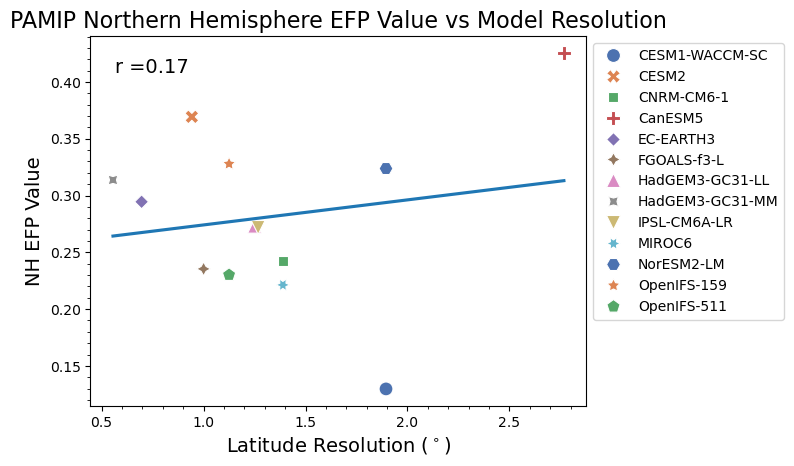

In [10]:
plt.figure()
scatter_plot = sns.scatterplot(
    x='Latitude Resolution', 
    y='NH EFP Value', 
    hue='Model', 
    style='Model', 
    data=df, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='Latitude Resolution', 
    y='NH EFP Value', 
    data=df, 
    scatter=False, 
    ax=scatter_plot,
    ci=None
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['Latitude Resolution'], y=df['NH EFP Value'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, fontsize=14)

ax.set_xlabel('Latitude Resolution ($^\\circ$)', fontsize=14)
ax.set_ylabel('NH EFP Value', fontsize=14)   
ax.set_title('PAMIP Northern Hemisphere EFP Value vs Model Resolution', fontsize=16)

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Southern Hemisphere

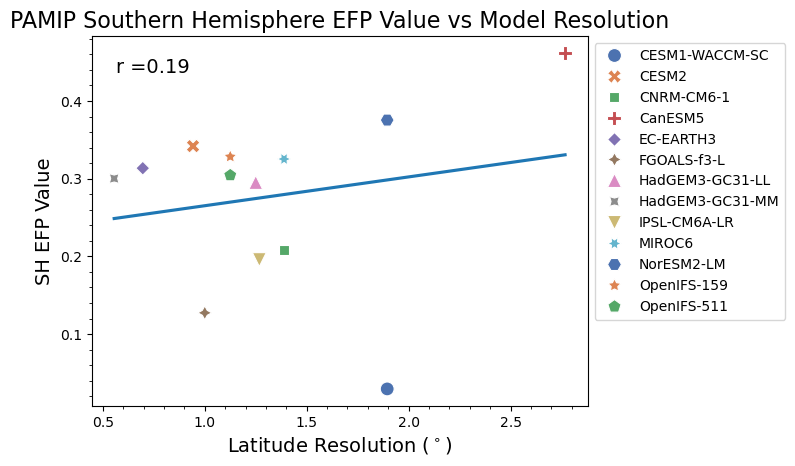

In [11]:
plt.figure()
scatter_plot = sns.scatterplot(
    x='Latitude Resolution', 
    y='SH EFP Value', 
    hue='Model', 
    style='Model', 
    data=df, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='Latitude Resolution', 
    y='SH EFP Value', 
    data=df, 
    scatter=False, 
    ax=scatter_plot,
    ci=None
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df['Latitude Resolution'], y=df['SH EFP Value'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, fontsize=14)

ax.set_xlabel('Latitude Resolution ($^\\circ$)', fontsize=14)
ax.set_ylabel('SH EFP Value', fontsize=14)   
ax.set_title('PAMIP Southern Hemisphere EFP Value vs Model Resolution', fontsize=16)

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [18]:
# df2 = df.drop(index=0) # drop CESM1
df2 = df.drop(index=3) # drop CanESM5
# df2 = df2.drop(index=10) # drop NorESM2
df2

,Model,NH EFP Value,SH EFP Value,Latitude Resolution
0,CESM1-WACCM-SC,0.1297,0.0295,1.894737
1,CESM2,0.3693,0.3419,0.942408
2,CNRM-CM6-1,0.2421,0.2082,1.389030
4,EC-EARTH3,0.2945,0.3135,0.695870
5,FGOALS-f3-L,0.2354,0.1274,1.000000
6,HadGEM3-GC31-LL,0.2730,0.2951,1.250000
7,HadGEM3-GC31-MM,0.3137,0.3002,0.555557
8,IPSL-CM6A-LR,0.2719,0.1959,1.267609
9,MIROC6,0.2213,0.3253,1.389030
10,NorESM2-LM,0.3238,0.3754,1.894737


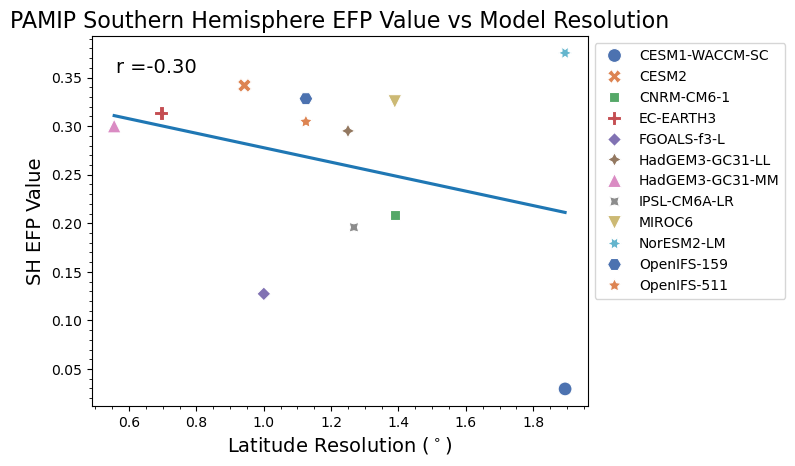

In [19]:
plt.figure()
scatter_plot = sns.scatterplot(
    x='Latitude Resolution', 
    y='SH EFP Value', 
    hue='Model', 
    style='Model', 
    data=df2, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='Latitude Resolution', 
    y='SH EFP Value', 
    data=df2, 
    scatter=False, 
    ax=scatter_plot,
    ci=None
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df2['Latitude Resolution'], y=df2['SH EFP Value'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, fontsize=14)

ax.set_xlabel('Latitude Resolution ($^\\circ$)', fontsize=14)
ax.set_ylabel('SH EFP Value', fontsize=14)   
ax.set_title('PAMIP Southern Hemisphere EFP Value vs Model Resolution', fontsize=16)

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()